In [1]:
import pandas as pd
import os
import sys
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Conv1D,MaxPooling1D,Reshape
from tensorflow.keras.layers import Bidirectional
from keras.utils import np_utils
from nltk.stem.porter import PorterStemmer
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import tensorflow as tf

In [2]:
train_csv = pd.read_csv("data/train.csv")
test_csv = pd.read_csv("data/test.csv")

print('train size = ' + str(train_csv.shape))
print('test size = ' + str(test_csv.shape))
train_csv.head(3)

train size = (256442, 6)
test size = (64110, 5)


id  tid1  tid2                                          title1_en  \
0  195611     0     1  There are two new old-age insurance benefits f...   
1  191474     2     3  "If you do not come to Shenzhen, sooner or lat...   
2   25300     2     4  "If you do not come to Shenzhen, sooner or lat...   

                                           title2_en      label  
0  Police disprove "bird's nest congress each per...  unrelated  
1  Shenzhen's GDP outstrips Hong Kong? Shenzhen S...  unrelated  
2  The GDP overtopped Hong Kong? Shenzhen clarifi...  unrelated

In [3]:
X = train_csv.drop('label', axis = 1)
y = train_csv['label']
X.shape

(256442, 5)

In [4]:
voc_size = 5000
message = X.copy()
message.reset_index(inplace = True)
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/yuro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yuro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(message)):
    head = message['title1_en'][i] + ' ' + message['title2_en'][i]
    head = re.sub('[^a-zA-Z]', ' ', head)
    head = head.lower()
    head = head.split()
    
    head = [ps.stem(word) for word in head if not word in stopwords.words('english')]
    head = ' '.join(head)
    corpus.append(head)

In [6]:
onehot_repr = [one_hot(words, voc_size) for words in corpus]
embeded_docs = pad_sequences(onehot_repr, padding = "pre")

dims = 100
model = Sequential()
model.add(Embedding(voc_size, dims))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(4))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dense(3, activation = "softmax"))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['mae', 'acc'])
print(model.summary())

2022-04-17 17:36:10.558122: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         500000    
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                        

In [7]:
print(y[:10])
import numpy as np

def convect_label(label:str):
    if label == 'agreed':
        return 0
    elif label == 'disagreed':
        return 1
    else:
        return 2

X_final = np.array(embeded_docs)
y_final = np.array([convect_label(l) for l in y])
y_final = np.array(tf.one_hot(y_final, 3))
print(y_final[:10])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.1, random_state=42)

0    unrelated
1    unrelated
2    unrelated
3    unrelated
4    unrelated
5       agreed
6       agreed
7       agreed
8    unrelated
9       agreed
Name: label, dtype: object
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [8]:
his = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 128)

Epoch 1/10
1804/1804 [==============================] - 534s 295ms/step - loss: 0.5383 - mae: 0.2275 - acc: 0.7489 - val_loss: 0.4803 - val_mae: 0.2014 - val_acc: 0.7822
Epoch 2/10
1804/1804 [==============================] - 540s 299ms/step - loss: 0.4461 - mae: 0.1852 - acc: 0.8022 - val_loss: 0.4455 - val_mae: 0.1791 - val_acc: 0.8030
Epoch 3/10
1804/1804 [==============================] - 544s 302ms/step - loss: 0.3962 - mae: 0.1623 - acc: 0.8287 - val_loss: 0.4246 - val_mae: 0.1677 - val_acc: 0.8173
Epoch 4/10
1804/1804 [==============================] - 518s 287ms/step - loss: 0.3617 - mae: 0.1468 - acc: 0.8463 - val_loss: 0.4125 - val_mae: 0.1596 - val_acc: 0.8250
Epoch 5/10
1804/1804 [==============================] - 518s 287ms/step - loss: 0.3361 - mae: 0.1355 - acc: 0.8585 - val_loss: 0.4177 - val_mae: 0.1460 - val_acc: 0.8282
Epoch 6/10
1804/1804 [==============================] - 519s 288ms/step - loss: 0.3137 - mae: 0.1260 - acc: 0.8695 - val_loss: 0.4121 - val_mae: 0.148

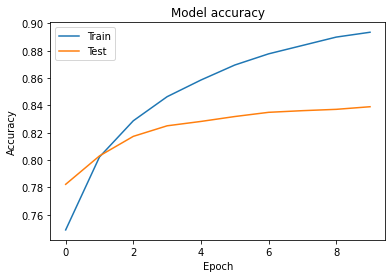

In [9]:
import matplotlib.pyplot as plt
plt.plot(his.history['acc'])
plt.plot(his.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
from sklearn.metrics import classification_report
        
pred = model.predict(X_test, batch_size=128)
pred = tf.argmax(pred, 1).numpy()
y_test = tf.argmax(y_test, 1).numpy()
print(pred)
print(y_test)
result = classification_report(y_test, pred)
print(result)

[0 2 2 ... 2 2 0]
[0 2 2 ... 2 2 2]
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      7465
           1       0.67      0.32      0.43       648
           2       0.86      0.91      0.89     17532

    accuracy                           0.84     25645
   macro avg       0.77      0.65      0.69     25645
weighted avg       0.83      0.84      0.83     25645



In [14]:
t_message = test_csv.copy()
t_message.reset_index(inplace = True)

tcorpus = []
for i in range(0, len(t_message)):
    head = t_message['title1_en'][i] + ' ' + t_message['title2_en'][i]
    head = re.sub('[^a-zA-Z]', ' ', head)
    head = head.lower()
    head = head.split()
    
    head = [ps.stem(word) for word in head if not word in stopwords.words('english')]
    head = ' '.join(head)
    tcorpus.append(head)
tonehot_repr = [one_hot(words, voc_size) for words in tcorpus]
tembeded_docs = pad_sequences(tonehot_repr, padding = "pre")
X_tfinal = np.array(tembeded_docs)
y_tpred = model.predict(X_tfinal, batch_size=128)

ids = test_csv['id'].to_numpy()
lid = tf.argmax(y_tpred, 1).numpy()
def convert_type(type:int):
    if type == 0:
        return 'agreed'
    elif type == 1:
        return 'disagreed'
    else:
        return 'unrelated'
labels = np.array([convert_type(l) for l in lid])
array = np.hstack((ids.reshape(-1,1), labels.reshape(-1,1)))
ret = pd.DataFrame(array, columns=['id', 'label'])
print(ret.head())
ret.to_csv('cnn_submission.csv', index=False)


       id      label
0  256442  unrelated
1  256443  unrelated
2  256444  unrelated
3  256445  unrelated
4  256446  unrelated
